In [37]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import pandas as pd
import matplotlib.pylab as plt
plt.style.use("classic")

In [ ]:
# Function to preprocess SPX or SPY DataFrame
def preprocess_options_data(df, strike_col="strike_price", bid_col="best_bid", offer_col="best_offer", cp_flag_col="cp_flag"):
    df["option_mid"] = (df[bid_col] + df[offer_col]) / 2
    df["strike_price_k"] = df[strike_col] / 1000
    df["option_type"] = df[cp_flag_col].map(lambda x: "call" if x == "C" else "put")
    return df

# Function to interpolate the risk-free rate
def interpolate_risstrike_K_free_rate(zero_rates_df, time_to_expiry):
    lower_bound = zero_rates_df[zero_rates_df["days"] <= time_to_expiry].iloc[-1]
    upper_bound = zero_rates_df[zero_rates_df["days"] >= time_to_expiry].iloc[0]
    rate = lower_bound["rate"] + (upper_bound["rate"] - lower_bound["rate"]) * (
        (time_to_expiry - lower_bound["days"]) / (upper_bound["days"] - lower_bound["days"])
    )
    return rate / 100

# Function to calculate forward price
def calculate_forward_price(spot_price, risstrike_K_free_rate, time_to_expiry):
    return spot_price * np.exp(risstrike_K_free_rate * time_to_expiry)

# Load the data
spx_options_df = pd.read_csv("spx_options.csv")
spy_options_df = pd.read_csv("SPY_options.csv")
zero_rates_df = pd.read_csv("zero_rates_20201201.csv")

# Preprocess SPX and SPY data
spx_options_df = preprocess_options_data(spx_options_df)
spy_options_df = preprocess_options_data(spy_options_df)

# Determine expiration date and time to expiry
exdate = sorted(spx_options_df["exdate"].unique())[1]
time_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp("2020-12-01")).days
T = time_to_expiry / 365

# Interpolate risk-free rate
r = interpolate_risstrike_K_free_rate(zero_rates_df, time_to_expiry)

# Filter SPX and SPY data for the selected expiration date
spx_options_filtered_df = spx_options_df[spx_options_df["exdate"] == exdate].copy()
spy_options_filtered_df = spy_options_df[spy_options_df["exdate"] == exdate].copy()

# Define SPX and SPY spot prices
spx_value = 3662.45
spy_value = 366.02

F_0_spx = calculate_forward_price(spx_value, r, T)
F_0_spy = calculate_forward_price(spy_value, r, T)

spx_options_black_scholes_df = spx_options_filtered_df.copy()
spy_options_blackscholes_df = spy_options_filtered_df.copy()
spx_options_bachelier_df = spx_options_filtered_df.copy()
spy_options_bachelier_df = spy_options_filtered_df.copy()


sabr_alpha_spx = 1.81650
sabr_beta_spx = 0.7
sabr_corr_spx = -0.40430
sabr_vol_spx = 2.79016


sabr_alpha_spy = 0.90813
sabr_beta_spy = 0.7
sabr_corr_spy = -0.48878
sabr_vol_spy = 2.72852


## Payoff Function

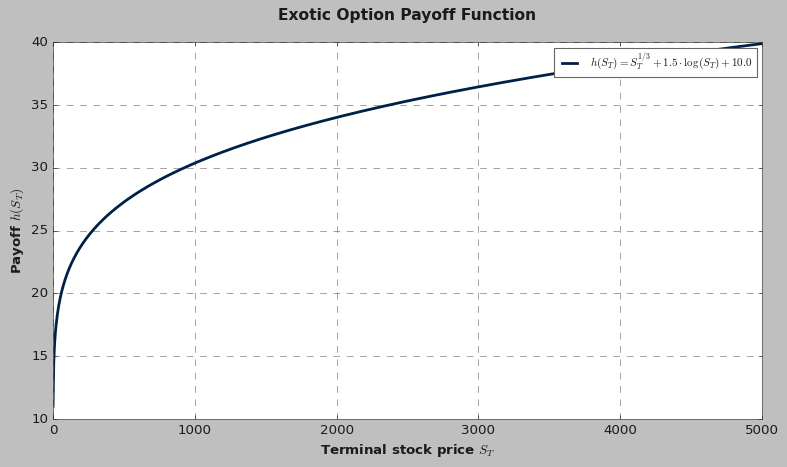

In [40]:



def h(K):
    K = np.where(np.abs(K) < 1e-12, 1e-12, K)
    return K**(1/3) + 1.5 * np.log(K) + 10


def h2(K):
    K = np.where(np.abs(K) < 1e-12, 1e-12, K)
    return -2/9 * K**(-5/3) - 3/2 * K**(-2)



strike_K_values = np.linspace(1, 5000, 1000)
h_values = h(strike_K_values)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(strike_K_values, h_values, 
        color='#002147',  
        linewidth=2.5,
        label=r'$h(S_T) = S_T^{1/3} + 1.5 \cdot \log(S_T) + 10.0$')

ax.set_xlabel("Terminal stock price $S_T$", fontsize=12, fontweight='bold')
ax.set_ylabel("Payoff $h(S_T)$", fontsize=12, fontweight='bold')
ax.set_title("Exotic Option Payoff Function", fontsize=14, fontweight='bold', pad=20)

ax.grid(True, linestyle='--', alpha=0.7)
for spine in ax.spines.values():
    spine.set_color('#666666')
    spine.set_linewidth(0.8)

ax.legend(frameon=True, 
         facecolor='white', 
         framealpha=1, 
         edgecolor='#666666',
         fontsize=10)

# ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [41]:
# Define option pricing functions for Black-Scholes model
def black_scholes_call_price(S_0, K, r, sigma, T):
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put_price(S_0, K, r, sigma, T):
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)

# Define option pricing functions for Bachelier model
def bachelier_call_price(S_0, K, r, sigma, T):
    d = (S_0 - K) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * ((S_0 - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d))

def bachelier_put_price(S_0, K, r, sigma, T):
    d = (S_0 - K) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * ((K - S_0) * norm.cdf(-d) + sigma * np.sqrt(T) * norm.pdf(-d))

# Generic function to calculate implied volatility
def implied_volatility(model_fnctn, S_0, K, r, price, T, payoff):
    try:
        if payoff.lower() == "call":
            implied_vol = brentq(lambda sigma: model_fnctn(S_0, K, r, sigma, T) - price, 1e-12, 1000.0)
        elif payoff.lower() == "put":
            implied_vol = brentq(lambda sigma: model_fnctn(S_0, K, r, sigma, T) - price, 1e-12, 1000.0)
        else:
            raise ValueError("Payoff type not recognized. Use 'call' or 'put'.")
    except Exception as e:
        implied_vol = np.nan
    return implied_vol

spx_options_black_scholes_df["vol_BS"] = spx_options_black_scholes_df.apply(
    lambda x: implied_volatility(
        black_scholes_call_price if x["option_type"] == "call" else black_scholes_put_price,
        spx_value,
        x["strike_price_k"],
        r,
        x["option_mid"],
        T,
        x["option_type"]
    ),
    axis=1
)

spy_options_blackscholes_df["vol_BS"] = spy_options_blackscholes_df.apply(
    lambda x: implied_volatility(
        black_scholes_call_price if x["option_type"] == "call" else black_scholes_put_price,
        spy_value,
        x["strike_price_k"],
        r,
        x["option_mid"],
        T,
        x["option_type"]
    ),
    axis=1
)

spx_options_black_scholes_df.dropna(subset=["vol_BS"], inplace=True)
spy_options_blackscholes_df.dropna(subset=["vol_BS"], inplace=True)

spx_options_bachelier_df["vol_bachelier"] = spx_options_bachelier_df.apply(
    lambda x: implied_volatility(
        bachelier_call_price if x["option_type"] == "call" else bachelier_put_price,
        spx_value,
        x["strike_price_k"],
        r,
        x["option_mid"],
        T,
        x["option_type"]
    ),
    axis=1
)

spy_options_bachelier_df["vol_bachelier"] = spy_options_bachelier_df.apply(
    lambda x: implied_volatility(
        bachelier_call_price if x["option_type"] == "call" else bachelier_put_price,
        spy_value,
        x["strike_price_k"],
        r,
        x["option_mid"],
        T,
        x["option_type"]
    ),
    axis=1
)

spx_options_bachelier_df.dropna(subset=["vol_bachelier"], inplace=True)
spy_options_bachelier_df.dropna(subset=["vol_bachelier"], inplace=True)

def calculate_mean_implied_vol(df, S_0, vol_column):
    call_df = df[df["option_type"] == "call"].set_index("strike_price_k")
    put_df = df[df["option_type"] == "put"].set_index("strike_price_k")
    strike_prices = df["strike_price_k"].unique()
    implied_vols = []

    for K in strike_prices:
        if S_0 < K:
            # Use call options for strikes above spot price
            if K in call_df.index:
                vol = call_df.at[K, vol_column]
            else:
                continue  # Skip if the data is missing
        else:
            # Use put options for strikes below spot price
            if K in put_df.index:
                vol = put_df.at[K, vol_column]
            else:
                continue  # Skip if the data is missing
        if not np.isnan(vol):
            implied_vols.append(vol)

    if implied_vols:
        return np.mean(implied_vols)
    else:
        return np.nan  # Return NaN if no implied volatilities are available

# Calculate mean implied volatilities for Black-Scholes model
spx_options_black_scholes_sigma_df = calculate_mean_implied_vol(spx_options_black_scholes_df, spx_value, "vol_BS")
spy_options_black_scholes_sigma_df = calculate_mean_implied_vol(spy_options_blackscholes_df, spy_value, "vol_BS")

# Calculate mean implied volatilities for Bachelier model
spx_options_bachelier_sigma_df = calculate_mean_implied_vol(spx_options_bachelier_df, spx_value, "vol_bachelier")
spy_options_bachelier_sigma_df = calculate_mean_implied_vol(spy_options_bachelier_df, spy_value, "vol_bachelier")



In [42]:
spx_options_black_scholes_sigma_df
spx_options_black_scholes_sigma_df

0.3864069451572272

In [43]:
spx_options_bachelier_sigma_df
spy_options_bachelier_sigma_df

126.74213915923983

SABR

In [44]:
def SABR(F_0, K, T, alpha, beta, rho, nu):
    X = K
    # if K is ATM forward
    if abs(F_0 - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24) * alpha**2/(F_0 ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha/(F_0 ** (1 - beta))
        numer3 = ((2 - 3 * rho**2)/24) * nu**2
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T)/(F_0 ** (1 - beta))
        SABR_sigma = VolAtm
    else:
        z = (nu/alpha) * ((F_0 * X) ** (0.5 * (1 - beta))) * np.log(F_0/X)
        zhi = np.log((((1 - 2 * rho * z + z**2)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*(alpha**2/((F_0 * X)**(1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha/((F_0 * X)**((1 - beta)/2))
        numer3 = ((2 - 3 * rho**2)/24) * nu**2
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta)**2/24) * (np.log(F_0/X))**2
        denom2 = (((1 - beta)**4)/1920) * ((np.log(F_0/X))**4)
        denom = ((F_0 * X)**((1 - beta)/2)) * (1 + denom1 + denom2) * zhi
        SABR_sigma = numer/denom
    return SABR_sigma

def sabr_call_price(S_0, K, r, T, alpha, beta, rho, nu):
    vol_SABR = SABR(S_0 * np.exp(r * T), K, T, alpha, beta, rho, nu)
    return black_scholes_call_price(S_0, K, r, vol_SABR, T)

def sabr_put_price(S_0, K, r, T, alpha, beta, rho, nu):
    vol_SABR = SABR(S_0 * np.exp(r * T), K, T, alpha, beta, rho, nu)
    return black_scholes_put_price(S_0, K, r, vol_SABR, T)

In [45]:
# experiment
# Generalized integrand function
def option_integrand(S_0, K, r, T, h2_fnctn, pricing_fnctn):
    return h2_fnctn(K) * pricing_fnctn(S_0, K, r, T)

# Generalized V₀ computation
def compute_V_0_dynamic(S_0, F_0, r, T, strike_K_values, strike_K_min, strike_K_max, h_fnctn, h2_fnctn, model_name, model_params):
    V_0_values = []
    if model_name == 'Black-Scholes':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: black_scholes_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: black_scholes_put_price(S_0, K, r, sigma, T)
    elif model_name == 'Bachelier':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: bachelier_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: bachelier_put_price(S_0, K, r, sigma, T)
    elif model_name == 'SABR':
        alpha = model_params['alpha']
        beta = model_params['beta']
        rho = model_params['rho']
        nu = model_params['nu']
        call_pricing_fnctn = lambda S_0, K, r, T: sabr_call_price(S_0, K, r, T, alpha, beta, rho, nu)
        put_pricing_fnctn = lambda S_0, K, r, T: sabr_put_price(S_0, K, r, T, alpha, beta, rho, nu)
    else:
        raise ValueError('Model not recognized.')

    for K in strike_K_values:
        integ_call = quad(lambda x: option_integrand(S_0, x, r, T, h2_fnctn, call_pricing_fnctn), K, strike_K_max)[0]
        integ_put = quad(lambda x: option_integrand(S_0, x, r, T, h2_fnctn, put_pricing_fnctn), strike_K_min, K)[0]
        V_0 = np.exp(-r * T) * h_fnctn(F_0) + integ_call + integ_put
        V_0_values.append(V_0)
    return V_0_values

# Plotting function
def plot_V_0(strike_K_values, V_0_values, title, color):
    plt.plot(strike_K_values, V_0_values, label=title, color=color)
    plt.xlabel("Strike price (K)")
    plt.ylabel("V₀ value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



def plotVo_compare(curves_dict, title="Comparison of V₀ Curves", xlabel="Strike Price (K)", ylabel="V₀ Value", figsize=(12, 8), legend_loc='best'):
    
    
    for label, (strike_K_values, V_0_values) in curves_dict.items():
        plt.plot(strike_K_values, V_0_values, label=label)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [46]:
# Define Strike Price Ranges for SPX and SPY
strike_K_values_spx = np.linspace(0.5 * F_0_spx, 1.5 * F_0_spx, 501)
strike_K_values_spy = np.linspace(0.5 * F_0_spy, 1.5 * F_0_spy, 501)
strike_K_min_spx = 0.0
strike_K_max_spx = 5000.0
strike_K_min_spy = 0.0
strike_K_max_spy = 5000.0

# Compute V₀ for SPX under Black-Scholes
model_params_black_scholes_spx = {'sigma': spx_options_black_scholes_sigma_df}
V_0_spx_black_scholes_values = compute_V_0_dynamic(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='Black-Scholes',
    model_params=model_params_black_scholes_spx
)

# Compute V₀ for SPX under Bachelier
model_params_bachelier_spx = {'sigma': spx_options_bachelier_sigma_df}
V_0_spx_bachelier_values = compute_V_0_dynamic(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='Bachelier',
    model_params=model_params_bachelier_spx
)

# Compute V₀ for SPX under SABR
model_params_SABR_spx = {
    'alpha': sabr_alpha_spx,
    'beta': sabr_beta_spx,
    'rho': sabr_corr_spx,
    'nu': sabr_vol_spx
}
V_0_spx_SABR_values = compute_V_0_dynamic(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='SABR',
    model_params=model_params_SABR_spx
)

# Compute V₀ for SPY under Black-Scholes
model_params_black_scholes_spy = {'sigma': spy_options_black_scholes_sigma_df}
V_0_spy_black_scholes_values = compute_V_0_dynamic(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='Black-Scholes',
    model_params=model_params_black_scholes_spy
)

# Compute V₀ for SPY under Bachelier
model_params_bachelier_spy = {'sigma': spy_options_bachelier_sigma_df}
V_0_spy_bachelier_values = compute_V_0_dynamic(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='Bachelier',
    model_params=model_params_bachelier_spy
)

# Compute V₀ for SPY under SABR
model_params_SABR_spy = {
    'alpha': sabr_alpha_spy,
    'beta': sabr_beta_spy,
    'rho': sabr_corr_spy,
    'nu': sabr_vol_spy
}
V_0_spy_SABR_values = compute_V_0_dynamic(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    h_fnctn=h,
    h2_fnctn=h2,
    model_name='SABR',
    model_params=model_params_SABR_spy
)


In [47]:
model_params_bachelier_spx

{'sigma': 748.4444276847913}

In [48]:
# Organize SPX Curves
curves_spx = {
    "SPX Black-Scholes": (strike_K_values_spx, V_0_spx_black_scholes_values),
    "SPX Bachelier": (strike_K_values_spx, V_0_spx_bachelier_values),
    "SPX SABR": (strike_K_values_spx, V_0_spx_SABR_values)
}

# Organize SPY Curves
curves_spy = {
    "SPY Black-Scholes": (strike_K_values_spy, V_0_spy_black_scholes_values),
    "SPY Bachelier": (strike_K_values_spy, V_0_spy_bachelier_values),
    "SPY SABR": (strike_K_values_spy, V_0_spy_SABR_values)
}

# Combine All Curves into a Single Dictionary
all_curves = {**curves_spx, **curves_spy}


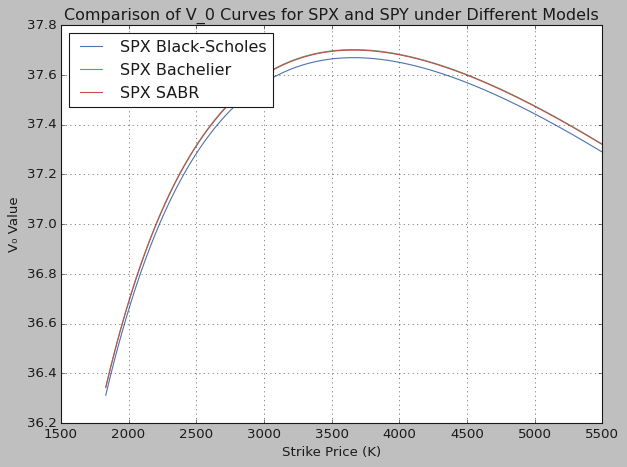

In [49]:
# Plot All V₀ Curves Together
plotVo_compare(
    curves_dict=curves_spx,
    title="Comparison of V_0 Curves for SPX and SPY under Different Models",
    xlabel="Strike Price (K)",
    ylabel="V₀ Value",
    figsize=(14, 10),
    legend_loc='upper left'
)


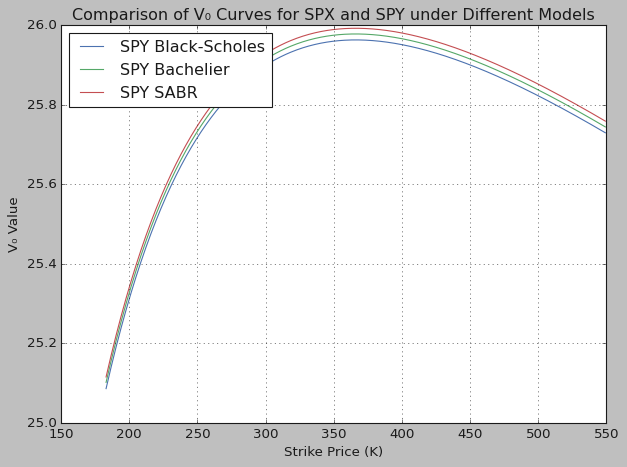

In [50]:
# Plot All V₀ Curves Together
plotVo_compare(
    curves_dict=curves_spy,
    title="Comparison of V₀ Curves for SPX and SPY under Different Models",
    xlabel="Strike Price (K)",
    ylabel="V₀ Value",
    figsize=(14, 10),
    legend_loc='upper left'
)


## 2 Integrate over the VAR

In [51]:
def integrated_variance_integrand(S_0, K, r, T, pricing_fnctn):
    return pricing_fnctn(S_0, K, r, T) / K**2


def compute_integrated_variance_over_K(S_0, F_0, r, T, strike_K_values, strike_K_min, strike_K_max, model_name, model_params):
    MF_var_values = []

    if model_name == 'Black-Scholes':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: black_scholes_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: black_scholes_put_price(S_0, K, r, sigma, T)
    elif model_name == 'Bachelier':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: bachelier_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: bachelier_put_price(S_0, K, r, sigma, T)
    elif model_name == 'SABR':
        alpha = model_params['alpha']
        beta = model_params['beta']
        rho = model_params['rho']
        nu = model_params['nu']
        call_pricing_fnctn = lambda S_0, K, r, T: sabr_call_price(S_0, K, r, T, alpha, beta, rho, nu)
        put_pricing_fnctn = lambda S_0, K, r, T: sabr_put_price(S_0, K, r, T, alpha, beta, rho, nu)
    else:
        raise ValueError('Model not recognized.')

    for K in strike_K_values:
        integ_call = quad(lambda x: integrated_variance_integrand(S_0, x, r, T, call_pricing_fnctn), K, strike_K_max)[0]
        integ_put = quad(lambda x: integrated_variance_integrand(S_0, x, r, T, put_pricing_fnctn), strike_K_min, K)[0]
        E_var = 2 * np.exp(r * T) * (integ_call + integ_put)
        MF_var = E_var / T
        MF_var_values.append(MF_var)

    return MF_var_values


def plot_integrated_variance(strike_K_values, MF_var_values, title, color):
    plt.plot(strike_K_values, MF_var_values, label=title, color=color)
    plt.xlabel("Strike price (K)")
    plt.ylabel("Model-free Integrated Variance")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_integrated_variance_compare(curves_dict, title="Comparison of Model-free Integrated Variance", xlabel="Strike Price (K)", ylabel="Model-free Integrated Variance", figsize=(12, 8), legend_loc='best'):
    plt.figure(figsize=figsize)
    
    for label, (strike_K_values, MF_var_values) in curves_dict.items():
        plt.plot(strike_K_values, MF_var_values, label=label)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


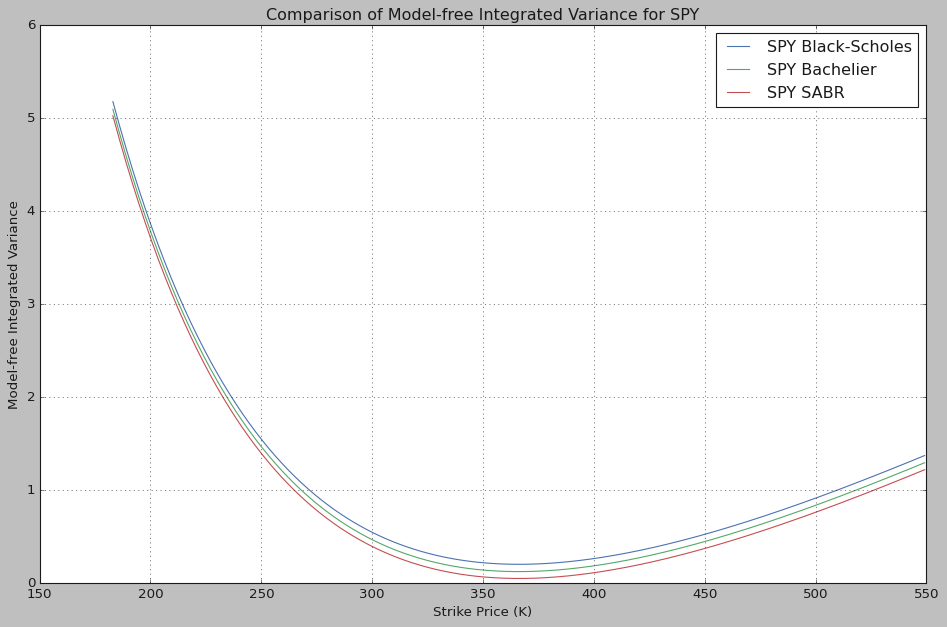

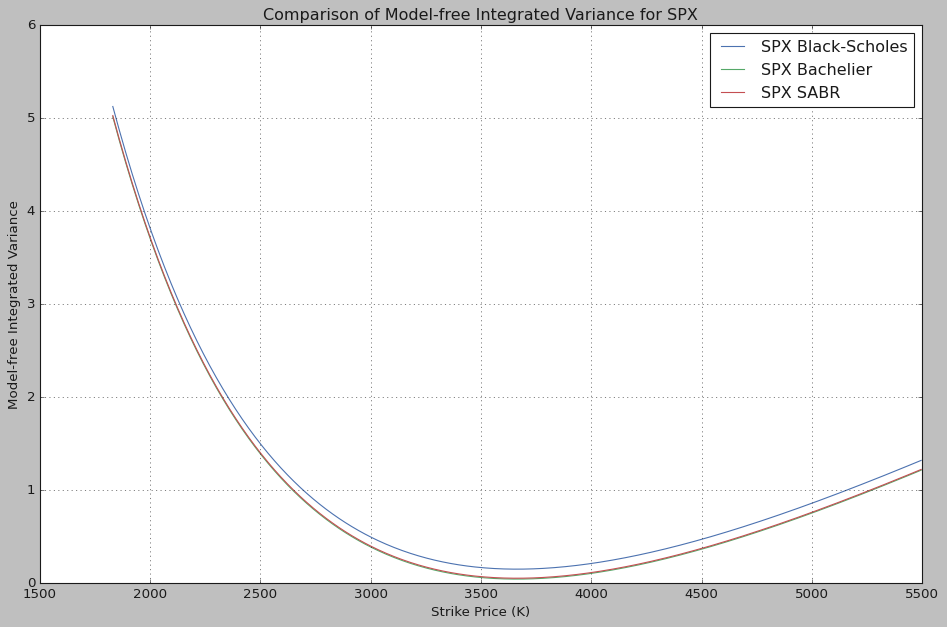

In [52]:

# Define Strike Price Ranges and Integration Limits
strike_K_values_spx = np.linspace(0.5 * F_0_spx, 1.5 * F_0_spx, 501)
strike_K_values_spy = np.linspace(0.5 * F_0_spy, 1.5 * F_0_spy, 501)
strike_K_min_spx = 0.0
strike_K_max_spx = 5000.0
strike_K_min_spy = 0.0
strike_K_max_spy = 5000.0

# Compute Integrated Variance for SPY under Black-Scholes
model_params_black_scholes_spy = {'sigma': spy_options_black_scholes_sigma_df}
MF_spy_black_scholes_values = compute_integrated_variance_over_K(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    model_name='Black-Scholes',
    model_params=model_params_black_scholes_spy
)

# Compute Integrated Variance for SPY under Bachelier
model_params_bachelier_spy = {'sigma': spy_options_bachelier_sigma_df}
MF_spy_bachelier_values = compute_integrated_variance_over_K(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    model_name='Bachelier',
    model_params=model_params_bachelier_spy
)

# Compute Integrated Variance for SPY under SABR
model_params_SABR_spy = {
    'alpha': sabr_alpha_spy,
    'beta': sabr_beta_spy,
    'rho': sabr_corr_spy,
    'nu': sabr_vol_spy
}
MF_spy_SABR_values = compute_integrated_variance_over_K(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spy,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    model_name='SABR',
    model_params=model_params_SABR_spy
)

# Organize SPY Curves
integrated_variance_curves_spy = {
    "SPY Black-Scholes": (strike_K_values_spy, MF_spy_black_scholes_values),
    "SPY Bachelier": (strike_K_values_spy, MF_spy_bachelier_values),
    "SPY SABR": (strike_K_values_spy, MF_spy_SABR_values)
}

# Plot Comparison for SPY
plot_integrated_variance_compare(
    curves_dict=integrated_variance_curves_spy,
    title="Comparison of Model-free Integrated Variance for SPY",
    xlabel="Strike Price (K)",
    ylabel="Model-free Integrated Variance"
)

# Compute Integrated Variance for SPX under Black-Scholes
model_params_black_scholes_spx = {'sigma': spx_options_black_scholes_sigma_df}
MF_spx_black_scholes_values = compute_integrated_variance_over_K(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    model_name='Black-Scholes',
    model_params=model_params_black_scholes_spx
)

# Compute Integrated Variance for SPX under Bachelier
model_params_bachelier_spx = {'sigma': spx_options_bachelier_sigma_df}
MF_spx_bachelier_values = compute_integrated_variance_over_K(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    model_name='Bachelier',
    model_params=model_params_bachelier_spx
)

# Compute Integrated Variance for SPX under SABR
model_params_SABR_spx = {
    'alpha': sabr_alpha_spx,
    'beta': sabr_beta_spx,
    'rho': sabr_corr_spx,
    'nu': sabr_vol_spx
}
MF_spx_SABR_values = compute_integrated_variance_over_K(
    S_0=spx_value,
    F_0=F_0_spx,
    r=r,
    T=T,
    strike_K_values=strike_K_values_spx,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    model_name='SABR',
    model_params=model_params_SABR_spx
)

# Organize SPX Curves
integrated_variance_curves_spx = {
    "SPX Black-Scholes": (strike_K_values_spx, MF_spx_black_scholes_values),
    "SPX Bachelier": (strike_K_values_spx, MF_spx_bachelier_values),
    "SPX SABR": (strike_K_values_spx, MF_spx_SABR_values)
}

# Plot Comparison for SPX
plot_integrated_variance_compare(
    curves_dict=integrated_variance_curves_spx,
    title="Comparison of Model-free Integrated Variance for SPX",
    xlabel="Strike Price (K)",
    ylabel="Model-free Integrated Variance"
)




C:\Users\fwoit\AppData\Local\Temp\ipykernel_38520\947096344.py:137: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\fwoit\AppData\Local\Temp\ipykernel_38520\947096344.py:138: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig(f"{label}_sensitivity_analysis.png", dpi=300, bbox_inches='tight')
C:\Users\fwoit\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


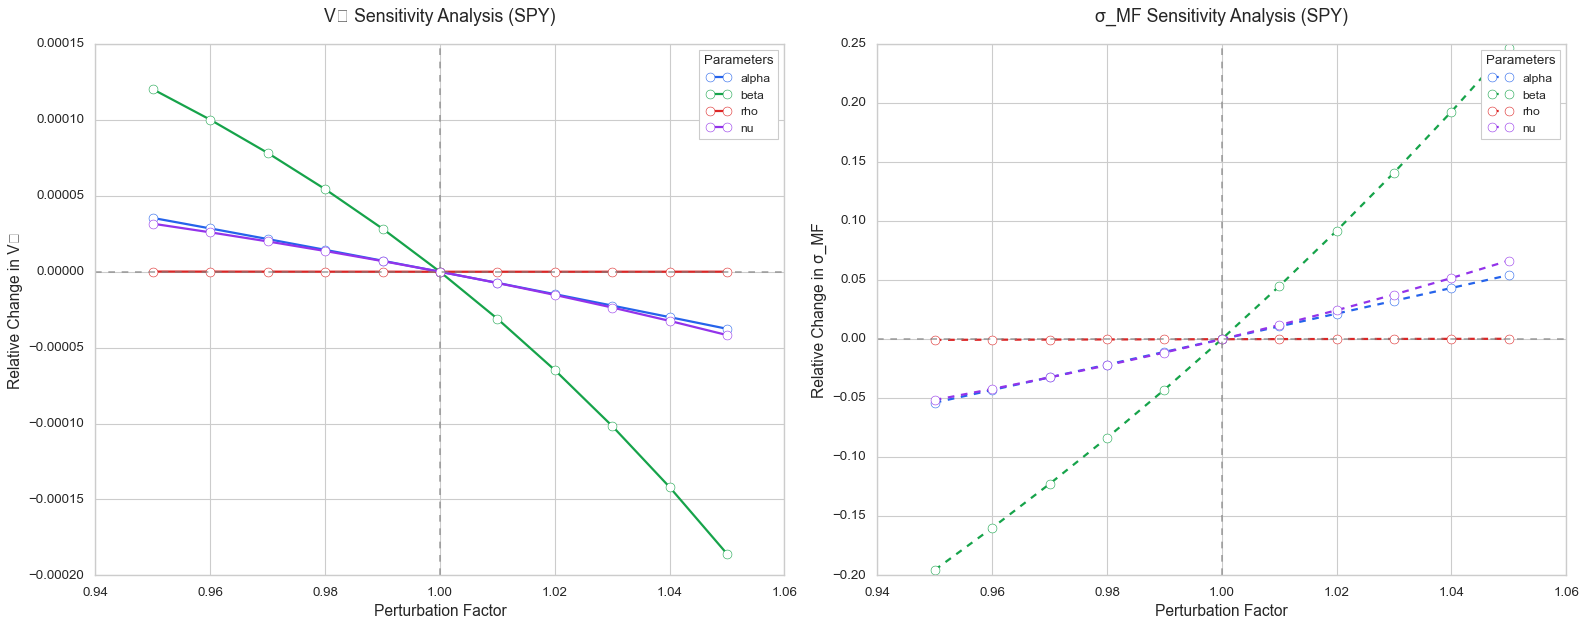

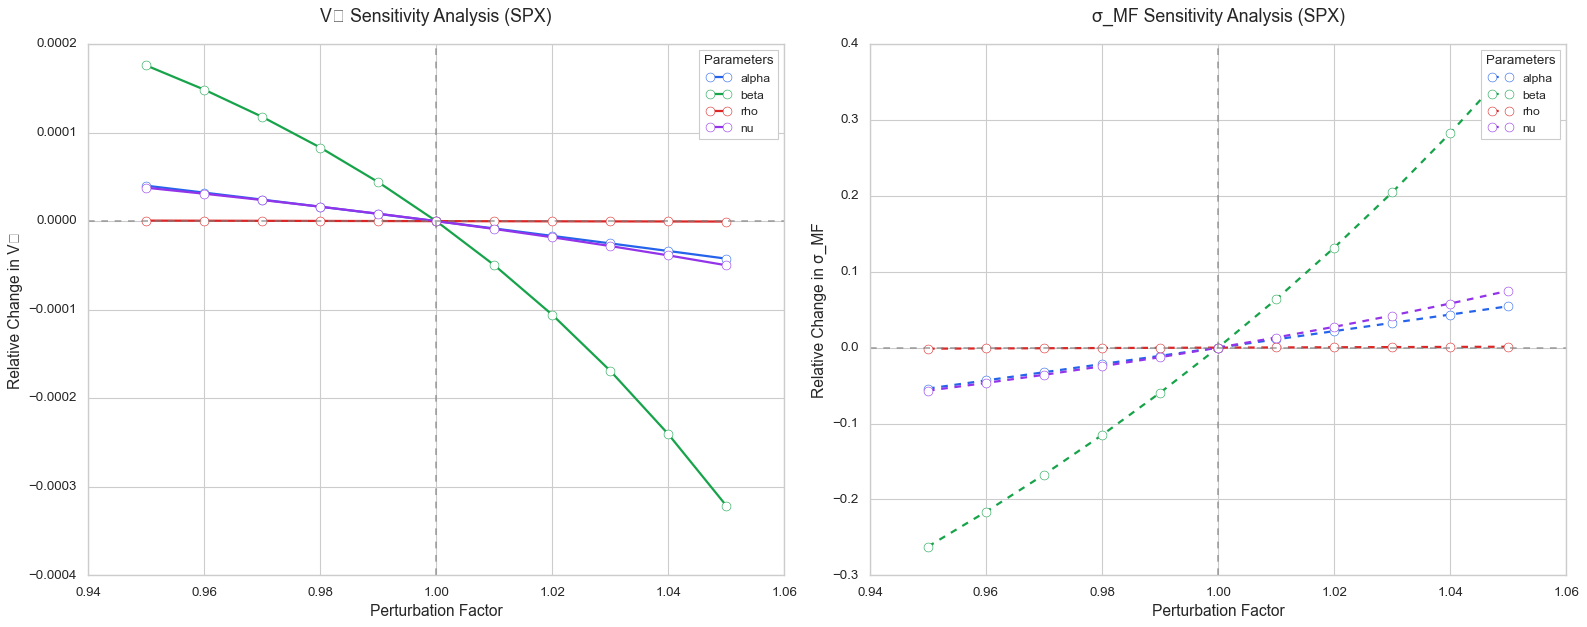

In [53]:

def compute_integrated_variance(S_0, F_0, r, T, strike_K_min, strike_K_max, model_name, model_params):
    if model_name == 'Black-Scholes':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: black_scholes_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: black_scholes_put_price(S_0, K, r, sigma, T)
    elif model_name == 'Bachelier':
        sigma = model_params['sigma']
        call_pricing_fnctn = lambda S_0, K, r, T: bachelier_call_price(S_0, K, r, sigma, T)
        put_pricing_fnctn = lambda S_0, K, r, T: bachelier_put_price(S_0, K, r, sigma, T)
    elif model_name == 'SABR':
        alpha = model_params['alpha']
        beta = model_params['beta']
        rho = model_params['rho']
        nu = model_params['nu']
        call_pricing_fnctn = lambda S_0, K, r, T: sabr_call_price(S_0, K, r, T, alpha, beta, rho, nu)
        put_pricing_fnctn = lambda S_0, K, r, T: sabr_put_price(S_0, K, r, T, alpha, beta, rho, nu)
    else:
        raise ValueError('Model not recognized.')

    integ_call = quad(lambda K: integrated_variance_integrand(S_0, K, r, T, call_pricing_fnctn), F_0, strike_K_max)[0]
    integ_put = quad(lambda K: integrated_variance_integrand(S_0, K, r, T, put_pricing_fnctn), strike_K_min, F_0)[0]

    E_var = 2 * np.exp(r * T) * (integ_call + integ_put)
    MF_var = E_var / T

    return E_var, MF_var

def compute_V_0_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha, beta, rho, nu):
    model_params = {'alpha': alpha, 'beta': beta, 'rho': rho, 'nu': nu}
    V_0_values = compute_V_0_dynamic(
        S_0=S_0,
        F_0=F_0,
        r=r,
        T=T,
        strike_K_values=[F_0],
        strike_K_min=strike_K_min,
        strike_K_max=strike_K_max,
        h_fnctn=h,
        h2_fnctn=h2,
        model_name='SABR',
        model_params=model_params
    )
    return V_0_values[0]

def compute_sigma_MF_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha, beta, rho, nu):
    model_params = {'alpha': alpha, 'beta': beta, 'rho': rho, 'nu': nu}
    E_var, MF_var = compute_integrated_variance(
        S_0=S_0,
        F_0=F_0,
        r=r,
        T=T,
        strike_K_min=strike_K_min,
        strike_K_max=strike_K_max,
        model_name='SABR',
        model_params=model_params
    )
    sigma_MF = np.sqrt(MF_var)
    return sigma_MF

def sensitivity_analysis_integrated_variance(S_0, F_0, r, T, strike_K_min, strike_K_max, base_params, perturbation_factors, parameters, label):
    alpha_base = base_params['alpha']
    beta_base = base_params['beta']
    rho_base = base_params['rho']
    nu_base = base_params['nu']

    V_0_base = compute_V_0_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha_base, beta_base, rho_base, nu_base)
    sigma_MF_base = compute_sigma_MF_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha_base, beta_base, rho_base, nu_base)

    V_0_sensitivities = {param: [] for param in parameters}
    sigma_MF_sensitivities = {param: [] for param in parameters}

    for param in parameters:
        for factor in perturbation_factors:
            perturbed_params = base_params.copy()
            perturbed_params[param] *= factor

            alpha = perturbed_params['alpha']
            beta = perturbed_params['beta']
            rho = perturbed_params['rho']
            nu = perturbed_params['nu']

            V_0 = compute_V_0_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha, beta, rho, nu)
            V_0_relative_change = (V_0 / V_0_base) - 1
            V_0_sensitivities[param].append(V_0_relative_change)

            sigma_MF = compute_sigma_MF_SABR(S_0, F_0, r, T, strike_K_min, strike_K_max, alpha, beta, rho, nu)
            sigma_MF_relative_change = (sigma_MF / sigma_MF_base) - 1
            sigma_MF_sensitivities[param].append(sigma_MF_relative_change)

    sns.set(style="whitegrid")
    color_dict = {
        'alpha': '#2563eb',
        'beta': '#16a34a',
        'rho': '#dc2626',
        'nu': '#9333ea'
    }

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    for param in parameters:
        axes[0].plot(perturbation_factors, V_0_sensitivities[param], 
                    label=param, 
                    color=color_dict[param],
                    marker='o',
                    markerfacecolor='white',
                    markeredgecolor=color_dict[param],
                    markersize=8,
                    linewidth=2)
    
    axes[0].axvline(x=1.0, color='gray', linestyle='--', alpha=0.7)
    axes[0].axhline(y=0.0, color='gray', linestyle='--', alpha=0.7)
    axes[0].set_title(f'V₀ Sensitivity Analysis ({label})', fontsize=16, pad=20)
    axes[0].set_xlabel('Perturbation Factor', fontsize=14)
    axes[0].set_ylabel('Relative Change in V₀', fontsize=14)
    axes[0].legend(title="Parameters")
    axes[0].tick_params(axis='both', which='major', labelsize=12)

    for param in parameters:
        axes[1].plot(perturbation_factors, sigma_MF_sensitivities[param], 
                    label=param, 
                    color=color_dict[param],
                    marker='o',
                    markerfacecolor='white',
                    markeredgecolor=color_dict[param],
                    markersize=8,
                    linestyle='--',
                    linewidth=2)

    axes[1].axvline(x=1.0, color='gray', linestyle='--', alpha=0.7)
    axes[1].axhline(y=0.0, color='gray', linestyle='--', alpha=0.7)
    axes[1].set_title(f'σ_MF Sensitivity Analysis ({label})', fontsize=16, pad=20)
    axes[1].set_xlabel('Perturbation Factor', fontsize=14)
    axes[1].set_ylabel('Relative Change in σ_MF', fontsize=14)
    axes[1].legend(title="Parameters")
    axes[1].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.savefig(f"{label}_sensitivity_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

perturbation_factors = np.linspace(0.95, 1.05, 11)
parameters = ["alpha", "beta", "rho", "nu"]

base_params_spy = {
    'alpha': sabr_alpha_spy,
    'beta': sabr_beta_spy,
    'rho': sabr_corr_spy,
    'nu': sabr_vol_spy
}

sensitivity_analysis_integrated_variance(
    S_0=spy_value,
    F_0=F_0_spy,
    r=r,
    T=T,
    strike_K_min=strike_K_min_spy,
    strike_K_max=strike_K_max_spy,
    base_params=base_params_spy,
    perturbation_factors=perturbation_factors,
    parameters=parameters,
    label='SPY'
)

base_params_spx = {
    'alpha': sabr_alpha_spx,
    'beta': sabr_beta_spx,
    'rho': sabr_corr_spx,
    'nu': sabr_vol_spx
}

sensitivity_analysis_integrated_variance(
    S_0=spx_value,         
    F_0=F_0_spx,             
    r=r,
    T=T,
    strike_K_min=strike_K_min_spx,
    strike_K_max=strike_K_max_spx,
    base_params=base_params_spx,
    perturbation_factors=perturbation_factors,
    parameters=parameters,
    label='SPX'
)


In [54]:
def get_results_dataframe(spx_price, SPY_price,
                          curves_spx, curves_spy,
                          integrated_variance_curves_spx, integrated_variance_curves_spy,
                          T):
    results = {
        'Metric': ['V_0', 'M', 'σ²_MF', 'σ']
    }

    def find_nearest_index(strike_K_values, price):
        idx = (np.abs(strike_K_values - price)).argmin()
        return idx

    models = ['Black-Scholes', 'Bachelier', 'SABR']

    for model in models:
        strike_K_values_spx, V_0_values_spx = curves_spx[f"SPX {model}"]
        _, MF_var_values_spx = integrated_variance_curves_spx[f"SPX {model}"]
        idx_spx = find_nearest_index(strike_K_values_spx, spx_price)
        V_0_spx = V_0_values_spx[idx_spx]
        MF_var_spx = MF_var_values_spx[idx_spx]
        E_var_spx = MF_var_spx * T
        sigma_spx = np.sqrt(MF_var_spx)
        key_spx = f"SPX ({model})"
        results[key_spx] = [V_0_spx, E_var_spx, MF_var_spx, sigma_spx]

    for model in models:
        strike_K_values_spy, V_0_values_spy = curves_spy[f"SPY {model}"]
        _, MF_var_values_spy = integrated_variance_curves_spy[f"SPY {model}"]
        idx_spy = find_nearest_index(strike_K_values_spy, SPY_price)
        V_0_spy = V_0_values_spy[idx_spy]
        MF_var_spy = MF_var_values_spy[idx_spy]
        E_var_spy = MF_var_spy * T
        sigma_spy = np.sqrt(MF_var_spy)
        key_spy = f"SPY ({model})"
        results[key_spy] = [V_0_spy, E_var_spy, MF_var_spy, sigma_spy]

    df_results = pd.DataFrame(results)
    df_results = df_results[['Metric', 'SPX (Black-Scholes)', 'SPY (Black-Scholes)',
                             'SPX (Bachelier)', 'SPY (Bachelier)',
                             'SPX (SABR)', 'SPY (SABR)']]
    df_results.set_index('Metric', inplace=True)
    df_formatted = df_results.applymap(lambda x: f"{x:.3f}")
    return df_formatted


spx_price = spx_value  
SPY_price = spy_value  

df = get_results_dataframe(spx_price=spx_price,
                           SPY_price=SPY_price,
                           curves_spx=curves_spx,
                           curves_spy=curves_spy,
                           integrated_variance_curves_spx=integrated_variance_curves_spx,
                           integrated_variance_curves_spy=integrated_variance_curves_spy,
                           T=T)

df


C:\Users\fwoit\AppData\Local\Temp\ipykernel_38520\2154121723.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted = df_results.applymap(lambda x: f"{x:.3f}")


,SPX (Black-Scholes),SPY (Black-Scholes),SPX (Bachelier),SPY (Bachelier),SPX (SABR),SPY (SABR)
Metric,,,,,,
V_0,37.670,25.963,37.703,25.978,37.700,25.993
M,0.018,0.025,0.005,0.015,0.006,0.006
σ²_MF,0.149,0.201,0.042,0.123,0.051,0.049
σ,0.386,0.448,0.205,0.350,0.227,0.221
